In [4]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print(f'func: {f.__name__} took: {te-ts:.4f} sec')
        return result

    return timed


def load_dataset(path):
    with open(path, 'rb') as f:
        train_data, test_data = pickle.load(f)
    
    X_train = torch.tensor(train_data[0], dtype=torch.float).unsqueeze(1)
    y_train = torch.tensor(train_data[1], dtype=torch.long)
    X_test = torch.tensor(test_data[0], dtype=torch.float).unsqueeze(1)
    y_test = torch.tensor(test_data[1], dtype=torch.long)
    return X_train, y_train, X_test, y_test


class MnistDataset():
    def __init__(self, X, y):
        assert X.shape[0] == y.shape[0]
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

class Trainer:
    
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2):
        self.model = model
        if opt_method == "sgdm":
            self.optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.9)
        elif opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        else:
            raise NotImplementedError("This optimization is not supported")
        
        self.epoch = epoch
        self.batch_size = batch_size
    
    @timeit
    def train(self, train_data, val_data, early_stop=True, verbose=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        
        train_loss_list, train_acc_list = [], []
        val_loss_list, val_acc_list = [], []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        loss_func = nn.CrossEntropyLoss()
        for n in tqdm(range(self.epoch), leave=False):
            self.model.train()
            for X_batch, y_batch in train_loader:
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
            train_loss, train_acc = self.evaluate(train_data)
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            
            val_loss, val_acc = self.evaluate(val_data)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_loss_list, label="Train")
            axes[0].plot(x_axis, val_loss_list, label="Validation")
            axes[0].set_title("Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_acc_list, label='Train')
            axes[1].plot(x_axis, val_acc_list, label='Validation')
            axes[1].set_title("Accuracy")
            axes[1].legend()
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "train_acc_list": train_acc_list,
            "val_loss_list": val_loss_list,
            "val_acc_list": val_acc_list,
        }
    
    def evaluate(self, data, print_acc=False):
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size, shuffle=True)
        loss_func = nn.CrossEntropyLoss()
        acc, loss = 0.0, 0.0
        for X_batch, y_batch in loader:
            with torch.no_grad():
                batch_importance = y_batch.shape[0] / len(data)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                batch_acc = torch.sum(torch.argmax(y_pred, axis=-1) == y_batch) / y_batch.shape[0]
                acc += batch_acc.detach().cpu().item() * batch_importance
                loss += batch_loss.detach().cpu().item() * batch_importance
        if print_acc:
            print(f"Accuracy: {acc:.3f}")
        return loss, acc
    

def KFoldCrossValidation(
    model_class, k, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', learning_rate=2e-3, batch_size=128, epoch=50, l2=0.0,
    early_break=False,
    **model_args
):
    test_data = MnistDataset(X_test, y_test)
    kf = KFold(n_splits=k, shuffle=True)
    train_acc_list, test_acc_list = [], []
    for i, (train_index, val_index) in enumerate(kf.split(X_train)):
        print(f"Fold {i}:")
        
        train_data = MnistDataset(X_train[train_index], y_train[train_index])
        val_data = MnistDataset(X_train[val_index], y_train[val_index])
        
        model = model_class(**model_args)
        
        trainer = Trainer(model, opt_method, learning_rate, batch_size, epoch, l2)
        res = trainer.train(train_data, val_data)
        train_acc_best = res['train_acc_list'][np.argmin(res['val_loss_list'])]
        test_loss, test_acc = trainer.evaluate(test_data)
        
        train_acc_list.append(train_acc_best)
        test_acc_list.append(test_acc)
        
        print(f"Training accuracy: {train_acc_best}")
        print(f"Test accuracy: {test_acc}")
        
        if early_break:
            break
    
    if not early_break:
        print("Final results:")
        print(f"Training accuracy: {np.mean(train_acc_list)}+/-{np.std(train_acc_list)}")
        print(f"Test accuracy: {np.mean(test_acc_list)}+/-{np.std(test_acc_list)}")


# Question 1

### For (a) and (b), DO NOT use `torchsummary` package. Please calculate by yourself. 



## (a)



Calculate the dimensionality of the output for the following
convolutions sequentially applied to a black and white MNIST input:
(i). Convolution Filter size of 2x2, number of filters 33, stride of 2,
padding of 0
(ii). Convolution Filter size of 3x3, number of filters 55, stride of 1, padding of 1
(iii). Convolution Filter size of 3x3, number of filters 77, stride of 1, padding of 1. Followed by a Max
Pooling with filter size of 2x2 and stride 2.

In [22]:
conv_layer = nn.Conv2d(1, 33, 2, 2, 0)
# in channels, out channels, kernal, stride, padding
conv_layer

Conv2d(1, 33, kernel_size=(2, 2), stride=(2, 2))

In [2]:
def out_dim(in_dim, kernel_size, padding, stride, dilation=1):
    return (in_dim + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

# MNIST depth 
mnist_input = 32

# Convolution 1
filter_size_i = 2
num_filters_i = 33
stride_i = 2
padding_i = 0
output_size_i = out_dim(mnist_input, filter_size_i, padding_i, stride_i)

# Convolution 2
filter_size_ii = 3
num_filters_ii = 55
stride_ii = 1
padding_ii = 1
output_size_ii = out_dim(output_size_i, filter_size_ii, padding_ii, stride_ii)

# Convolution 3
filter_size_iii = 3
num_filters_iii = 77
stride_iii = 1
padding_iii = 1
output_size_iii = out_dim(output_size_ii, filter_size_iii, padding_iii, stride_iii)

# Max Pooling
filter_size_pooling = 2
stride_pooling = 2
output_size_pooling = out_dim(output_size_iii, filter_size_pooling, 0, stride_pooling)

# Output results
print(f"(i). Convolution: {output_size_i}x{output_size_i}")
print(f"(ii). Convolution: {output_size_ii}x{output_size_ii}")
print(f"(iii). Convolution: {output_size_iii}x{output_size_iii}")
print(f"Max Pooling: {num_filters_iii}x{output_size_pooling}x{output_size_pooling}")

(i). Convolution: 16x16
(ii). Convolution: 16x16
(iii). Convolution: 16x16
Max Pooling: 77x8x8


## (b)

The MNIST data set was, in fact, in color (RGB). This means the depth of the input image would
be 3. Calculate the dimensionality of the output for the following convolutions sequentially applied to a
RGB MNIST input:
(i). Convolution Filter size of 2x2, number of filters 33, stride of 2, padding of 0
(ii). Convolution Filter size of 3x3, number of filters 55, stride of 1, padding of 1. Followed by a max
pooling layer of kernel size 3x3, stride of 1, padding of 0
(iii). Convolution Filter size of 3x3, number of filters 77, stride of 1, padding of 1. Followed by a Max
Pooling with filter size of 2x2 and stride 2.

In [1]:
def out_dim(in_dim, kernel_size, padding, stride, dilation=1):
    return (in_dim + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

# MNIST depth 
mnist_input = 32

# Convolution 1
filter_size_i = 2
num_filters_i = 33
stride_i = 2
padding_i = 0
output_size_i = out_dim(mnist_input, filter_size_i, padding_i, stride_i)

# Convolution 2
filter_size_ii = 3
num_filters_ii = 55
stride_ii = 1
padding_ii = 1
output_size_ii = out_dim(output_size_i, filter_size_ii, padding_ii, stride_ii)

# Max Pooling
filter_size_pooling_1 = 3
stride_pooling_1 = 1
output_size_pooling_1 = out_dim(output_size_ii, filter_size_pooling_1, 0, stride_pooling_1)

# Convolution 3
filter_size_iii = 3
num_filters_iii = 77
stride_iii = 1
padding_iii = 1
output_size_iii = out_dim(output_size_pooling_1, filter_size_iii, padding_iii, stride_iii)

# Max Pooling
filter_size_pooling_2 = 2
stride_pooling_2 = 2
output_size_pooling_2 = out_dim(output_size_iii, filter_size_pooling_2, 0, stride_pooling_2)

# Output results
print(f"(i). Convolution: {output_size_i}x{output_size_i}")
print(f"(ii). Convolution: {output_size_ii}x{output_size_ii}")
print(f"Max Pooling 1: {output_size_pooling_1}x{output_size_pooling_1}")
print(f"(iii). Convolution: {output_size_iii}x{output_size_iii}")
print(f"Max Pooling 2: {num_filters_iii}x{output_size_pooling_2}x{output_size_pooling_2}")

(i). Convolution: 16x16
(ii). Convolution: 16x16
Max Pooling 1: 14x14
(iii). Convolution: 14x14
Max Pooling 2: 77x7x7


## (c)

### Instructions: For training stability, it is recommened to normalize the data by dividing its max value as you did in HW6.

In [6]:
# Normalize data
X_train, y_train, X_test, y_test = load_dataset("mnist.pkl")
X_train /= torch.max(X_train)
X_test /= torch.max(X_test)

Fold 0:


func: train took: 147.5856 sec
Training accuracy: 0.9836750000000011
Test accuracy: 0.9750999999999995
Fold 1:


func: train took: 144.5373 sec
Training accuracy: 0.9888750000000008
Test accuracy: 0.9773999999999998
Fold 2:


func: train took: 146.5702 sec
Training accuracy: 0.9911499999999998
Test accuracy: 0.9773999999999994
Final results:
Training accuracy: 0.9879000000000006+/-0.0031285646336081416
Test accuracy: 0.9766333333333329+/-0.0010842303978194105


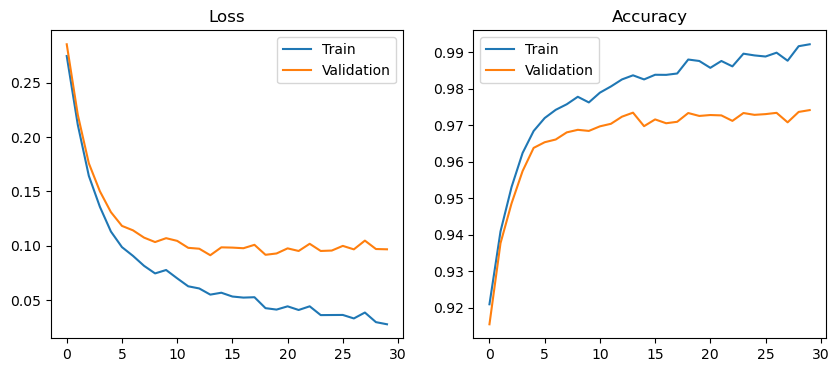

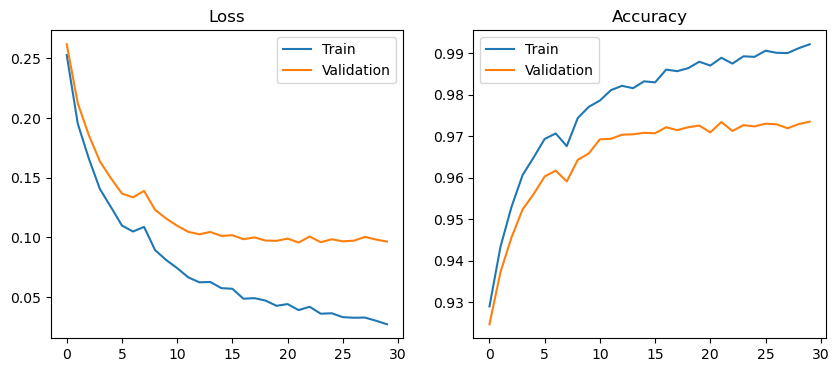

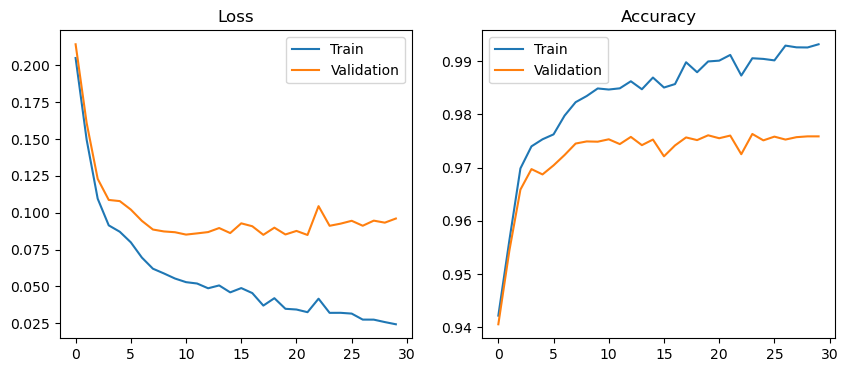

In [27]:
class ShallowCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size = 5, stride = 1, padding = 2), # Conv Layer
            nn.ReLU(), # ReLU
            nn.Flatten(), # Flatten
            nn.Linear(3072,10), # Linear Layer
        )
    
    def forward(self, x):
        return self.layers(x)
    

KFoldCrossValidation(ShallowCNN, 3, X_train, y_train, X_test, y_test, learning_rate=1e-3, epoch=30, l2=1e-5)

## (d)

Fold 0:


func: train took: 3185.3191 sec
Training accuracy: 0.995949999999999
Test accuracy: 0.988900000000001
Fold 1:


func: train took: 5952.8934 sec
Training accuracy: 0.9984749999999974
Test accuracy: 0.9886000000000008
Fold 2:


func: train took: 3807.7804 sec
Training accuracy: 0.9981999999999974
Test accuracy: 0.9904000000000005
Final results:
Training accuracy: 0.9975416666666647+/-0.001131063904275039
Test accuracy: 0.9893000000000008+/-0.0007874007874010051


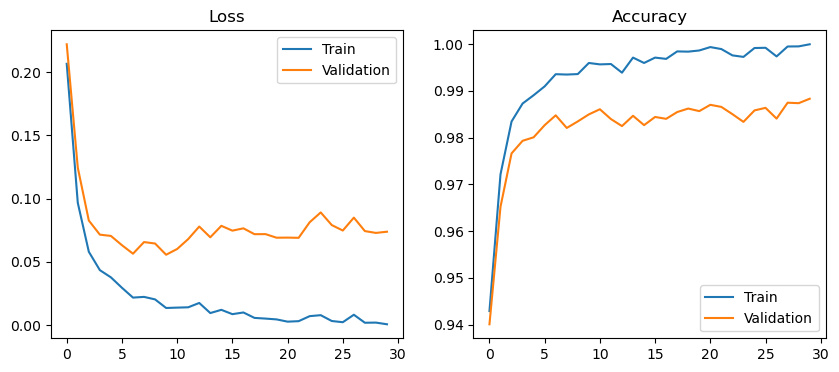

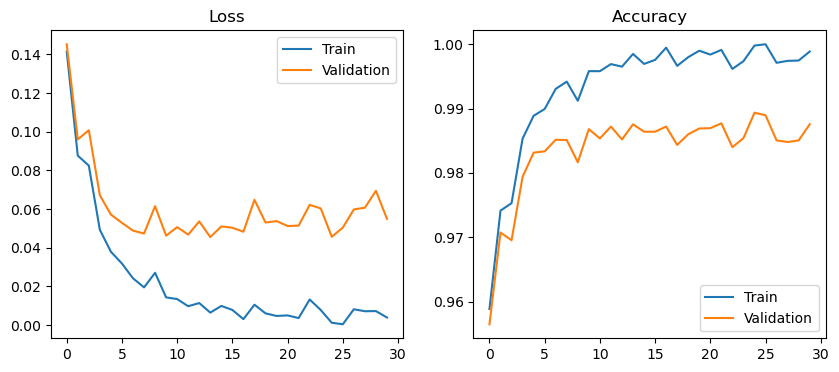

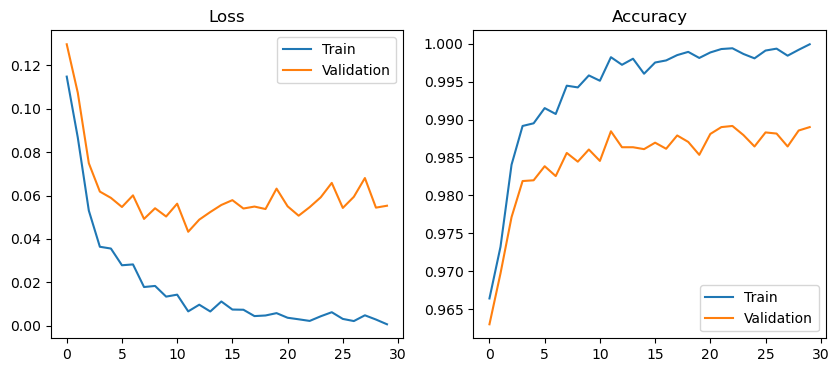

In [55]:
class DeepCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.ModuleList([
            nn.Conv2d(1, 70, kernel_size = 5, stride = 1, padding = 2), # Conv Layer 1
            nn.Conv2d(70, 70, kernel_size = 5, stride = 1, padding = 2)  # Conv Layer 2
        ])
        self.pooling = nn.MaxPool2d(kernel_size = 2) # Pooling
        self.fc = nn.ModuleList([
            nn.Linear(70*8*8,10), # Linear Layer 1
            nn.Linear(10,10) # Linear Layer 2
        ])
        self.activation = nn.ReLU() # ReLU activation function
        self.flatten = nn.Flatten() # Flatten Layer
        
    def forward(self, x):
        for i in range(2):
            x = self.pooling(self.activation(self.conv[i](x)))
        x = self.flatten(x)
        x = self.activation(self.fc[0](x))
        x = self.fc[1](x)
        return x

KFoldCrossValidation(DeepCNN, 3, X_train, y_train, X_test, y_test, learning_rate = 1e-3, epoch = 30, l2 = 1e-5)

# Question 2

### Instructions: You can set `early_break=True` in `KFoldCrossValidation` function to just to a train-validation round instead of doing 3-fold.

## (a)


In [46]:
class ResNet(nn.Module):
    def __init__(self, use_resnet=True, use_batch_norm=True):
        super(ResNet, self).__init__()
        self.conv = nn.ModuleList([
            nn.Conv2d(1, 6, kernel_size = 5, stride = 1, padding = 0), # Conv Layer 1
            nn.Conv2d(6, 12, kernel_size = 5, stride = 1, padding = 0)  # Conv Layer 2
        ])
        self.bn1 = nn.BatchNorm2d(6) # Batch Norm 1
        self.bn2 = nn.BatchNorm2d(12) # Batch Norm 2
        self.pooling = nn.AvgPool2d(2) # Pooling
        self.fc = nn.ModuleList([
            nn.Linear(300, 300), # Linear Layer (300->300)
            nn.Linear(300, 10), # Linear Layer (300->10)
        ])
        self.activation = nn.ReLU() # ReLU
        self.flatten = nn.Flatten() # Flatten
        
        self.softmax = nn.Softmax(dim=-1)
        
        self.use_resnet = use_resnet
        self.use_batch_norm = use_batch_norm
        
    def forward(self, x):
        x = self.conv[0](x)
        if self.use_batch_norm:
            x = self.bn1(x) 
        x = self.pooling(self.activation(x))
        x = self.conv[1](x)
        if self.use_batch_norm:
            x = self.bn2(x) 
        x = self.pooling(self.activation(x))
        x = self.flatten(x)
        out = self.fc[0](x)
        if self.use_resnet:
            out += x
        out = self.fc[1](out)
        out = self.softmax(out)
        return out

Fold 0:


func: train took: 256.3208 sec
Training accuracy: 0.9940999999999992
Test accuracy: 0.9885000000000005


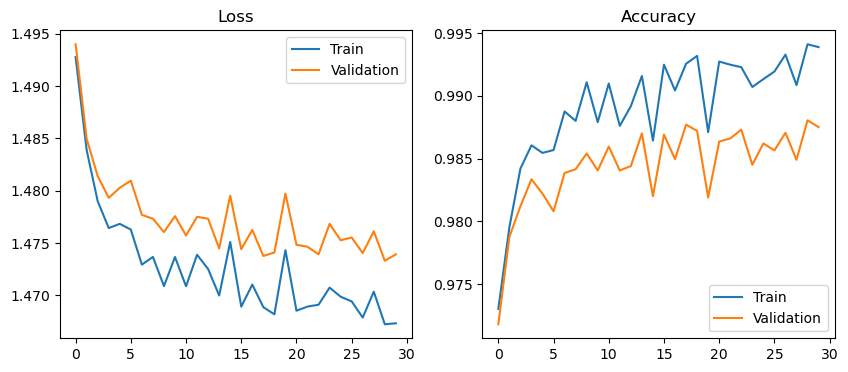

In [47]:
# Run with BatchNorm & Residual
KFoldCrossValidation(
    ResNet, 3,
    X_train, y_train, X_test, y_test, learning_rate=1e-3, epoch=30,
    early_break=True,
    use_resnet=True, use_batch_norm=True
)

Fold 0:


func: train took: 237.4717 sec
Training accuracy: 0.9905250000000002
Test accuracy: 0.9849000000000002


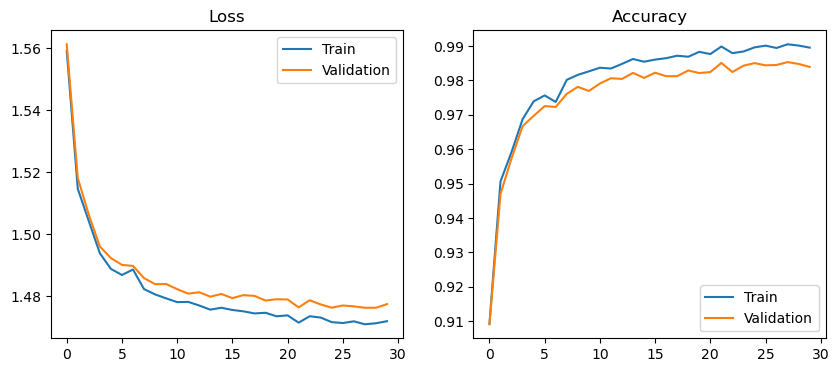

In [48]:
# Run without BatchNorm by setting `use_batch_norm=False`
KFoldCrossValidation(
    ResNet, 3,
    X_train, y_train, X_test, y_test, learning_rate=1e-3, epoch=30,
    early_break=True, 
    use_resnet=True, use_batch_norm=False
)

Using batch normalization gives better accuracy

## (b)

Fold 0:


func: train took: 85.3282 sec
Training accuracy: 0.977950000000001
Test accuracy: 0.9781999999999992


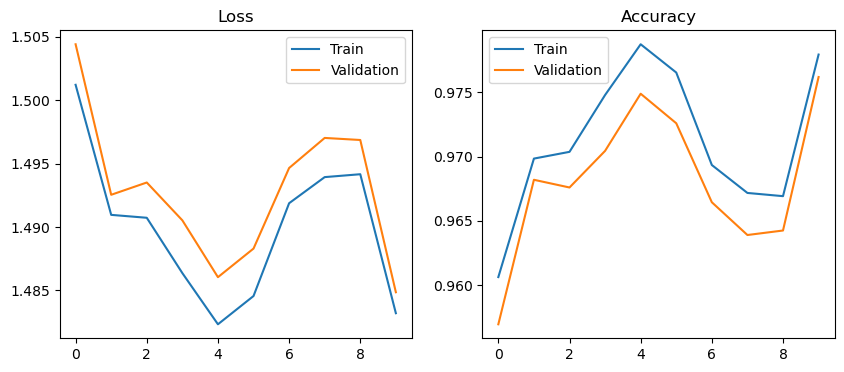

In [50]:
# Run with BatchNorm & Residual
KFoldCrossValidation(
    ResNet, 3,
    X_train, y_train, X_test, y_test, learning_rate=5e-3, epoch=10,
    early_break=True, 
    use_resnet=True, use_batch_norm=True
)

Fold 0:


func: train took: 86.0156 sec
Training accuracy: 0.9779250000000016
Test accuracy: 0.9789999999999995


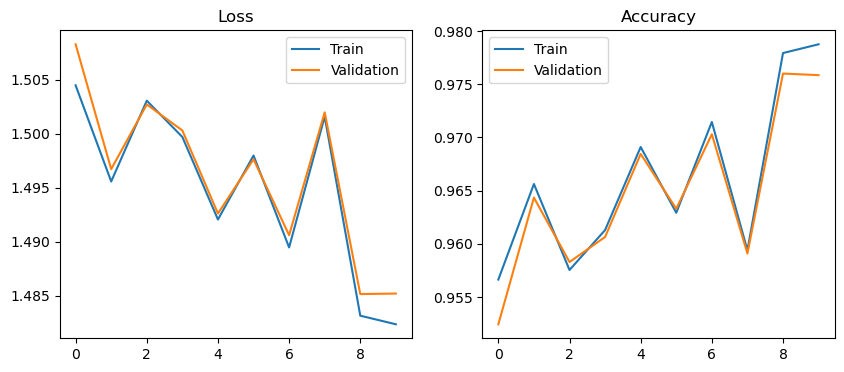

In [54]:
# Run without Residual
KFoldCrossValidation(
    ResNet, 3, 
    X_train, y_train, X_test, y_test, learning_rate=5e-3, epoch=10,
    early_break=True, 
    use_resnet=False, use_batch_norm=True
)

Both with and without the skip connection led to similar test accuracies and training rates